## Advanced Lane Line Detection Laboratory

In this notebook, a pipeline of advanced lane line detection algorithm will be developed and experimented.

In [1]:
# Packages import
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
%matplotlib inline

### Step 0 - Show Test Image

In [9]:
import os
Imag_dir = "../test_images/"
TestImag_list = os.listdir(Imag_dir)

test_images = []
for i in range (8):
    image = mpimg.imread(Imag_dir + TestImag_list[i])
    test_images.append(image)

Height,Width,channel = test_images[1].shape
print(Height,Width,channel)

720 1280 3


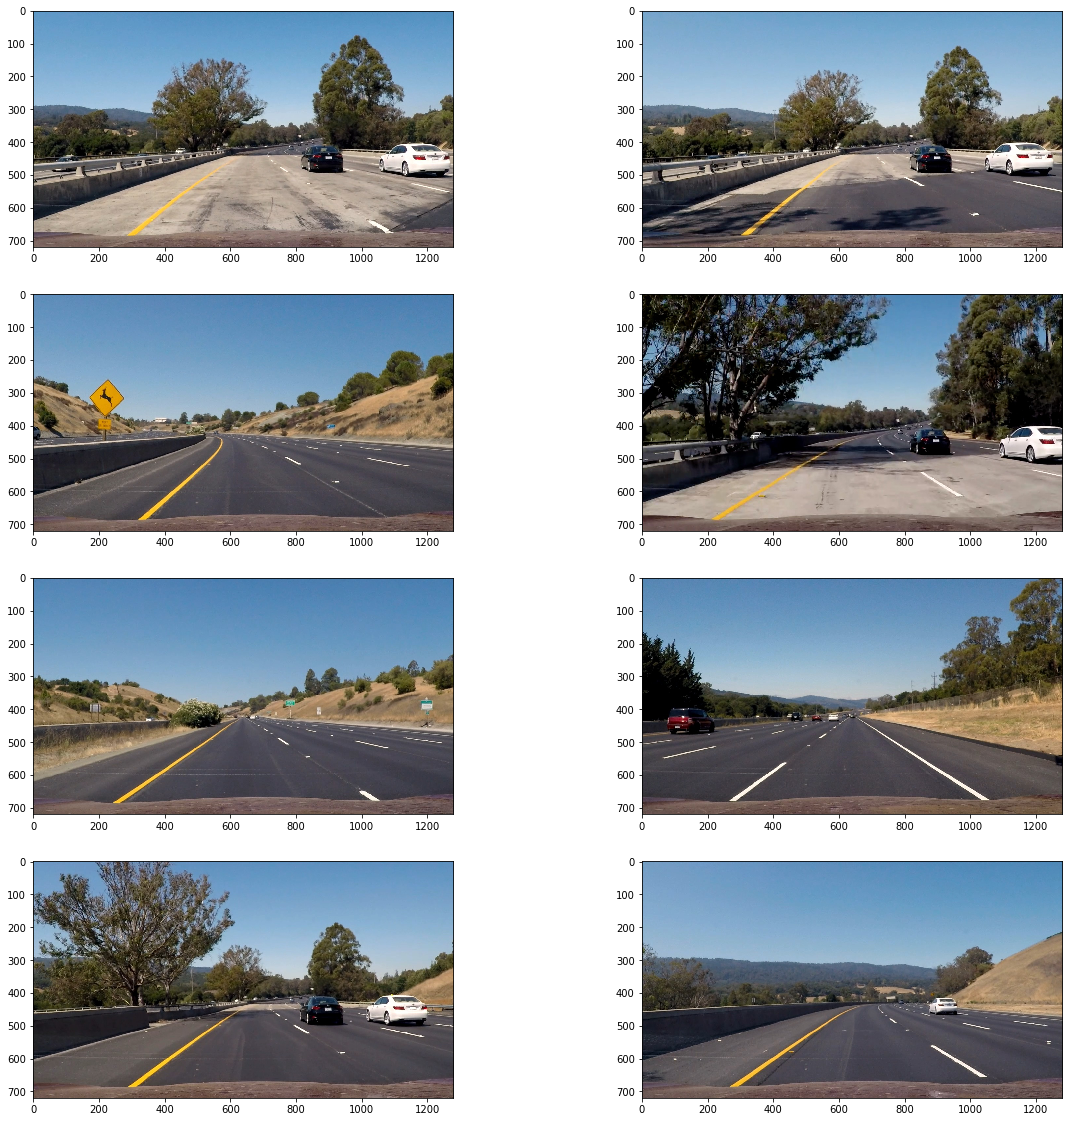

In [6]:
fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    ax.imshow(test_images[i])
    

### Step 1 - Camera Calibration

#### Preparing Calibration Points

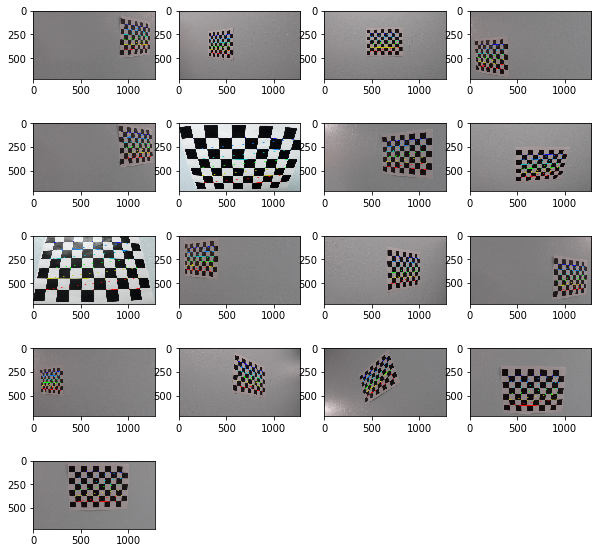

In [41]:
#-------------Prepare for the chessboard images-------------
chessbImages = glob.glob("../camera_cal/calibration*.jpg")

#--------------going through each image to obtain the imagepoints and objectpoints--------------
imagespoints = []
objectpoints = []
cornerImag = []

# preload the object points
objp = np.zeros((6*9,3),np.float32)
objp[:,0:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # generate an array with each row containing (x,y,z) for each conner

# looping through each image
for fname in chessbImages:
    img = cv2.imread(fname)
    
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find chessboard corner
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, draw corners
    if ret == True:
        imagespoints.append(corners)
        objectpoints.append(objp)
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        cornerImag.append(img)
        
# show the chessboard images with corners marked 
fig = plt.figure(figsize = (10,10))
for i in range (len(cornerImag)):
    ax = fig.add_subplot(4,5,i+1)
    ax.imshow(cornerImag[i])

#### Calculate the Correction Matrix

In [70]:
img = cv2.imread("../camera_cal/calibration1.jpg")
imag_size = (img.shape[1],img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagespoints, imag_size, None, None)

# Save the camera calibration result
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ))

Now, we can try some images to see how the calibration works

Text(0.5, 1.0, 'undistorted image')

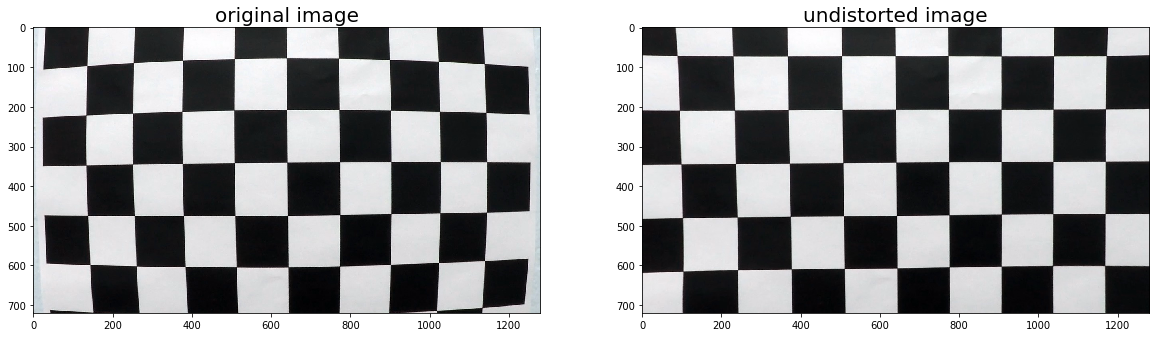

In [69]:
img = cv2.imread("../camera_cal/calibration1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)

f,(ax1,ax2) = plt.subplots(1, 2, figsize = (20,10))
ax1.imshow(img)
ax1.set_title("original image", fontsize = 20)
ax2.imshow(dst)
ax2.set_title("undistorted image", fontsize = 20)

### Step 2 - Undistort the Images

In [4]:
# Read in the saved undistortion matrix
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

undisImag = []
for i in range (8):
    undisImag.append(cv2.undistort(test_images[i], mtx, dist, None, mtx))

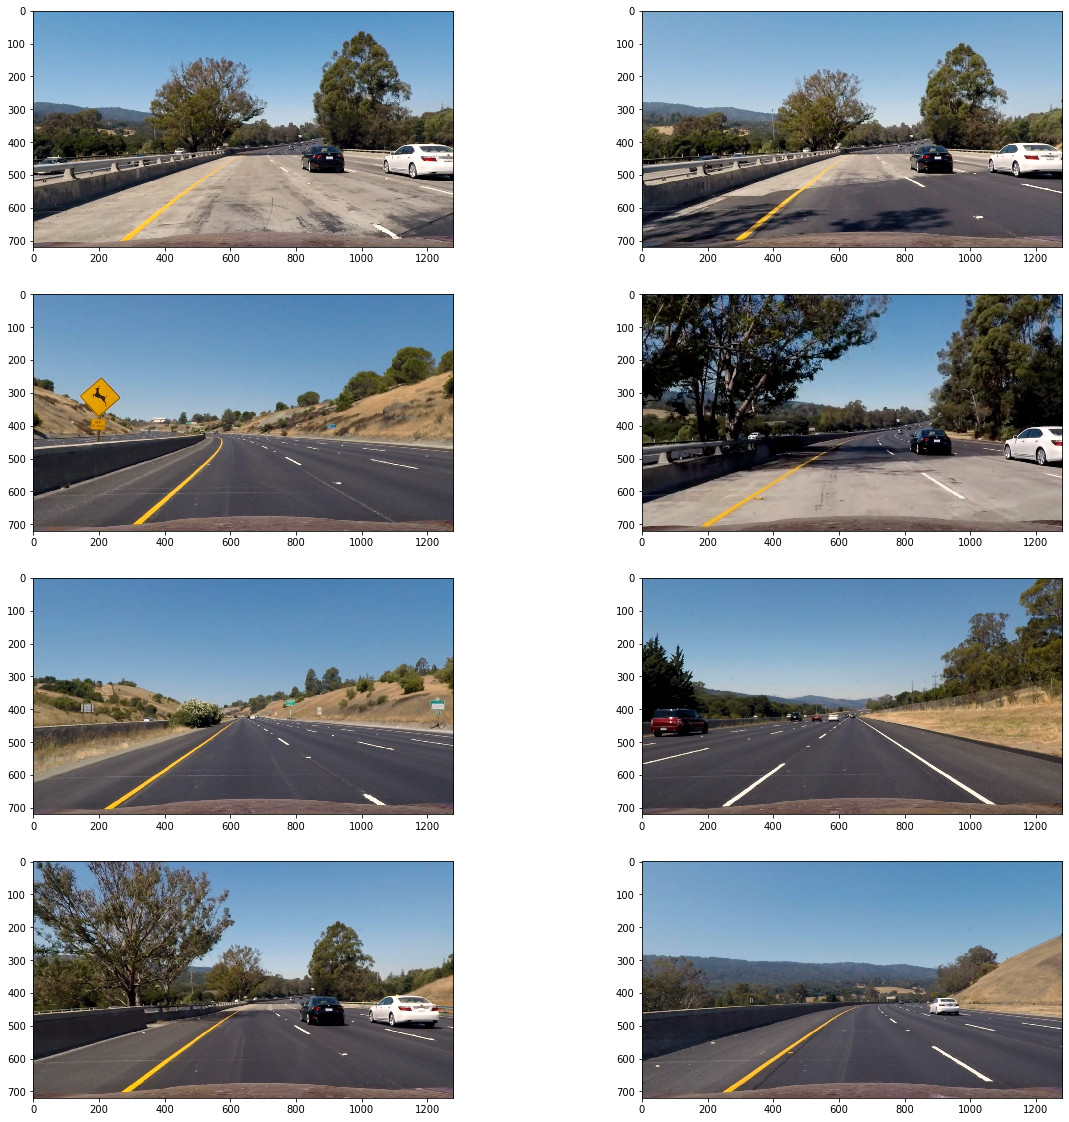

In [5]:

fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    ax.imshow(undisImag[i])

### Step 3 - Perspective Transformation

In [11]:
# define a function to do the perspective transformation
def warp_imag(img,dst,src):
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped,M,Minv

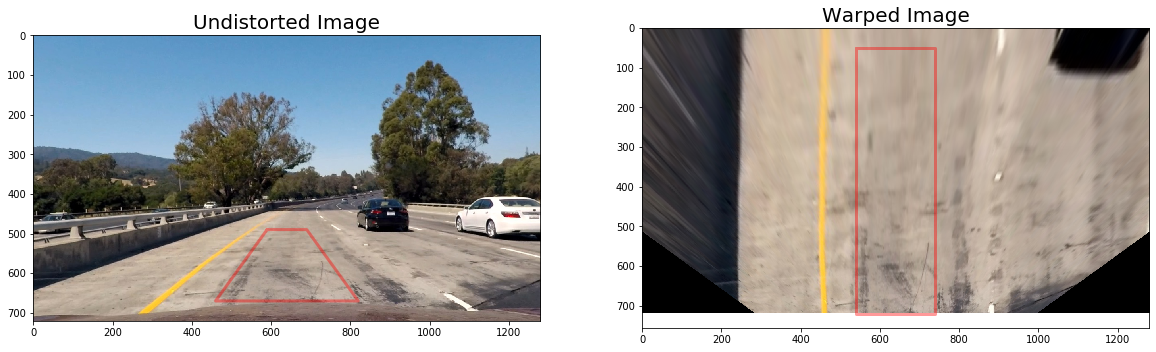

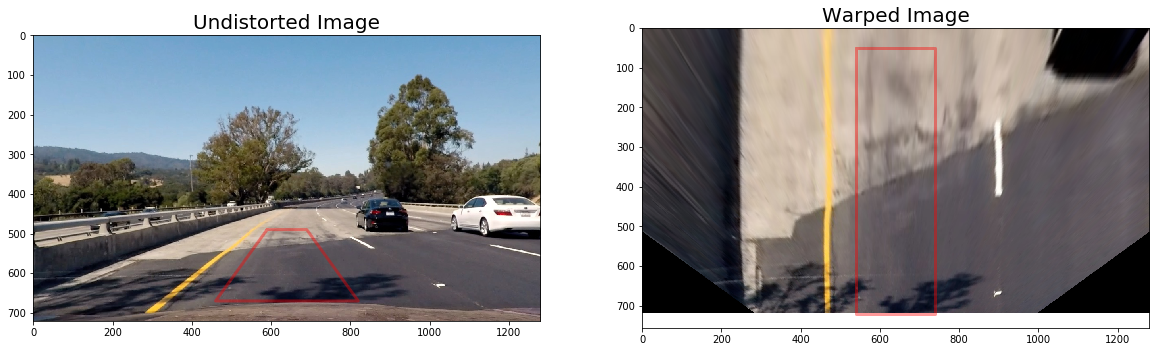

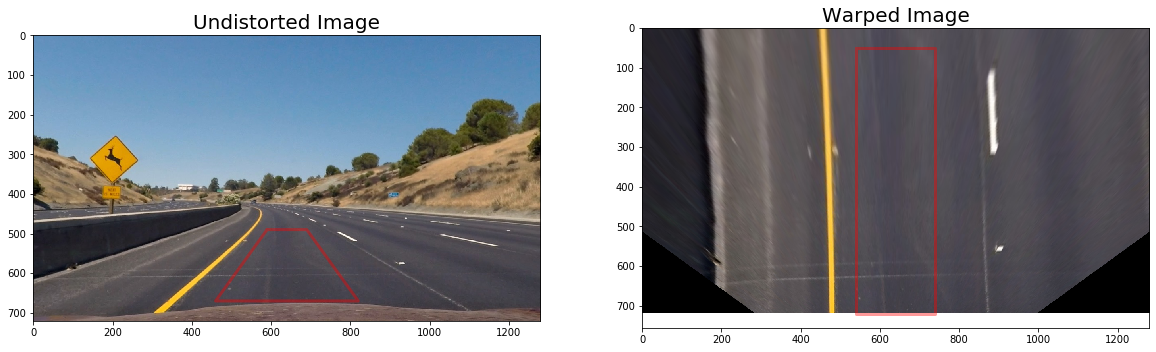

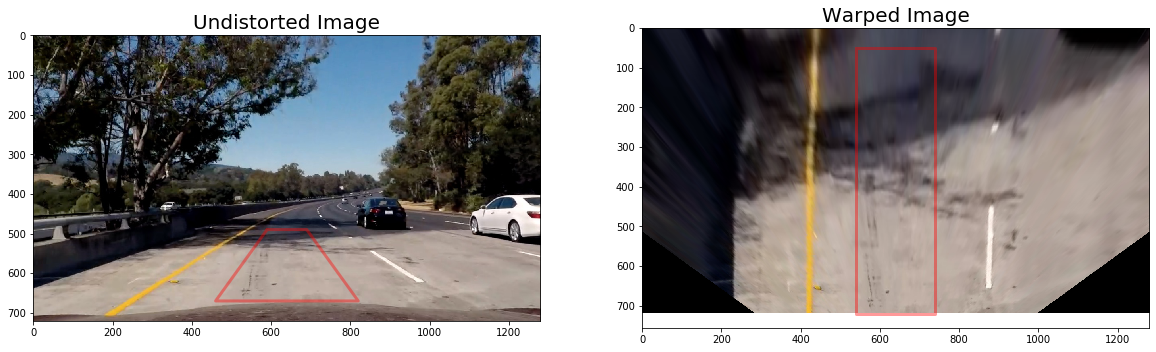

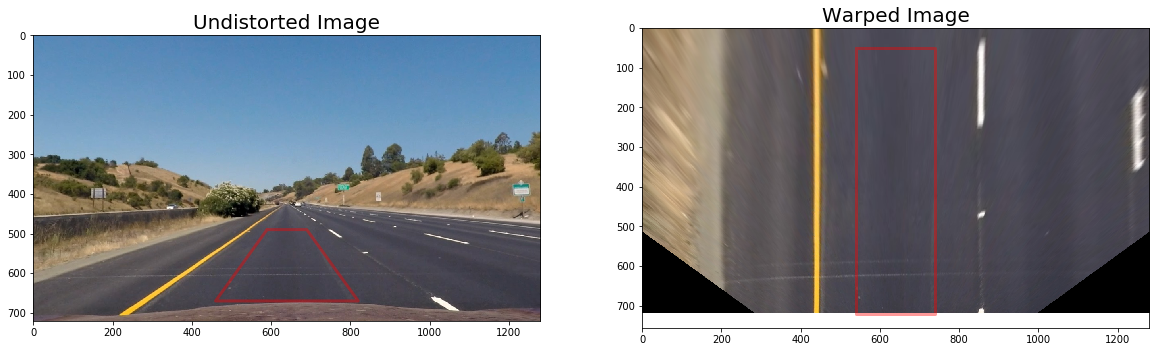

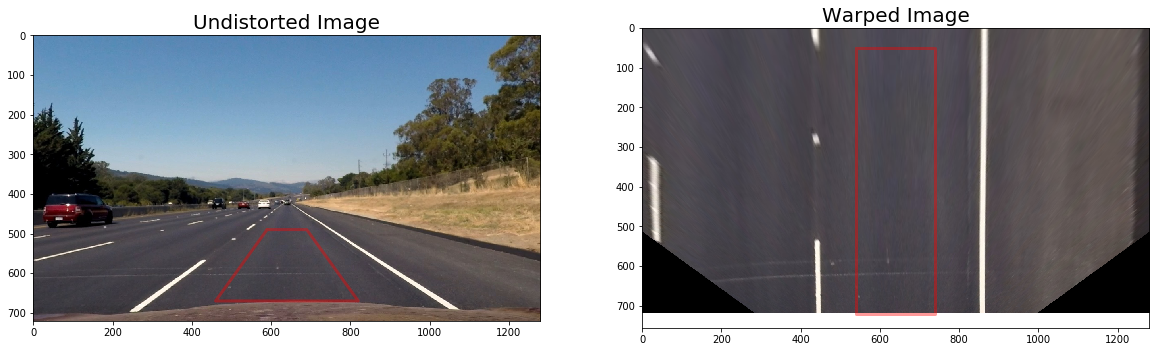

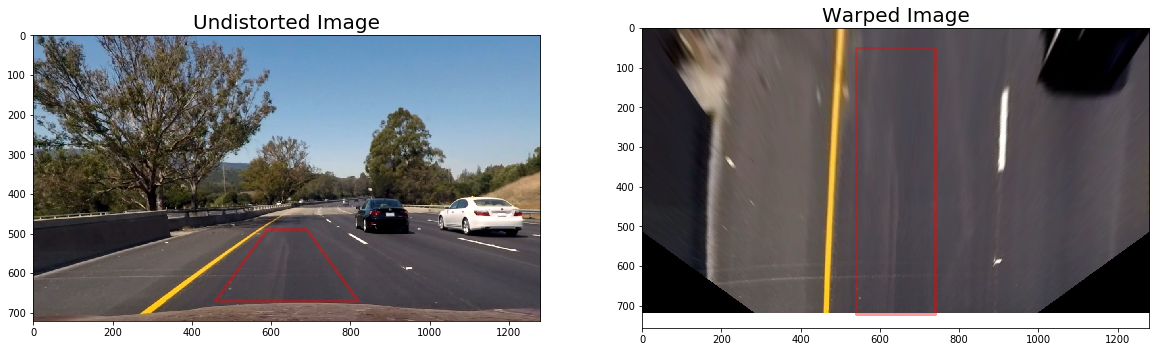

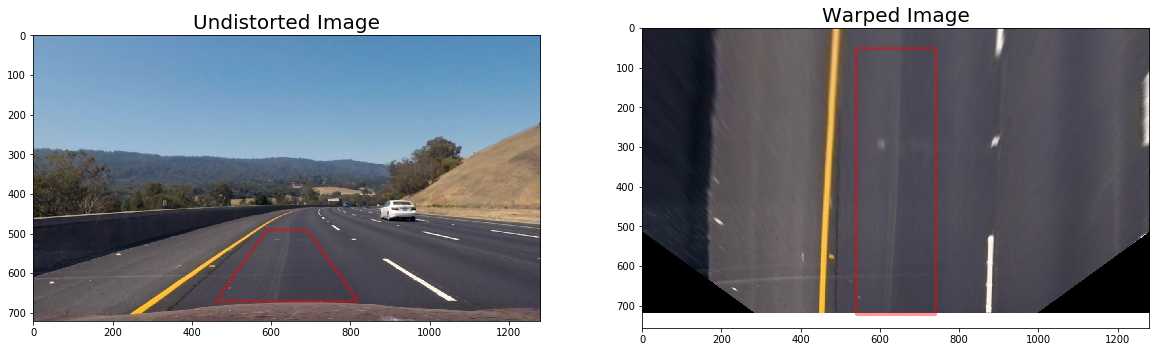

In [44]:
# define source and destination points for transform
xoff_1  = 50
xoff_2 = 180
xoff_3 = 100
yoff = 130
src = np.float32([((Width//2-xoff_1),(Height//2)+yoff),
                  ((Width//2+xoff_1),(Height//2)+yoff), 
                  ((Width//2-xoff_2),670), 
                  ((Width//2+xoff_2),670)])

dst = np.float32([((Width//2-xoff_3),50),
                  ((Width//2+xoff_3),50),
                  ((Width//2-xoff_3),Height),
                  ((Width//2+xoff_3),Height)])

warpedImg = []
for i in range (8):
    
    wImg,M,Minv = warp_imag(undisImag[i],dst,src)
    warpedImg.append(wImg)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(undisImag[i])
    x = [src[0][0],src[1][0],src[3][0],src[2][0],src[0][0]]
    y = [src[0][1],src[1][1],src[3][1],src[2][1],src[0][1]]
    ax1.plot(x, y, color='r', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(wImg)
    x = [dst[0][0],dst[1][0],dst[3][0],dst[2][0],dst[0][0]]
    y = [dst[0][1],dst[1][1],dst[3][1],dst[2][1],dst[0][1]]
    ax2.plot(x, y, color='r', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax2.set_title('Warped Image', fontsize=20)